0) Installer / importer les bibliothèques

In [1]:
pip install pandas numpy matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


ÉTAPE 2 — Charger le dataset + vérifications de base

In [3]:
df = pd.read_csv("C:\\Users\\dell\\Desktop\\pfe\\trendify\\Data\\social_media_viral_content_dataset.csv")

print(df.shape)
print(df.isna().sum())
print(df.duplicated().sum())
df["is_viral"].value_counts(normalize=True)


(2000, 15)
post_id            0
platform           0
content_type       0
topic              0
language           0
region             0
post_datetime      0
hashtags           0
views              0
likes              0
comments           0
shares             0
engagement_rate    0
sentiment_score    0
is_viral           0
dtype: int64
0


is_viral
1    0.699
0    0.301
Name: proportion, dtype: float64

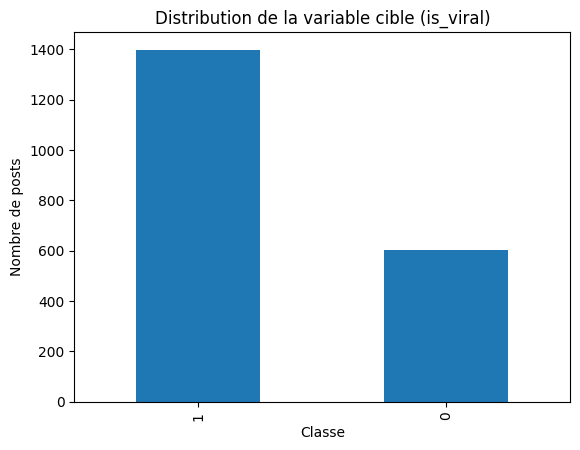

In [5]:
df["is_viral"].value_counts().plot(kind="bar")
plt.title("Distribution de la variable cible (is_viral)")
plt.xlabel("Classe")
plt.ylabel("Nombre de posts")
plt.show()


## 🔍 Interprétation et analyse initiale du dataset

- Le jeu de données est composé de **2000 observations (samples)** et de **15 variables (features)**, ce qui correspond à un **dataset tabulaire de taille moyenne**, bien adapté aux algorithmes de **Machine Learning supervisé**.

- La variable cible **`is_viral`** est **binaire**, ce qui permet de formuler le problème comme une **tâche de classification supervisée binaire**.

- L’analyse de la qualité des données montre une **absence de valeurs manquantes (*missing values*)** et de **doublons**, garantissant une **bonne intégrité du dataset** et éliminant le besoin de techniques d’**imputation** ou de **déduplication**.

- La distribution des classes met en évidence un **déséquilibre modéré des labels**, avec environ **69.9 % d’exemples positifs** contre **30.1 % d’exemples négatifs**, ce qui peut biaiser les modèles optimisant uniquement l’**accuracy**.

👉 Par conséquent, des métriques d’évaluation plus robustes telles que le **F1-score**, la **precision**, le **recall** et l’**AUC-ROC** seront privilégiées pour l’évaluation des performances des modèles.


In [6]:
df.head()


,post_id,platform,content_type,topic,language,region,post_datetime,hashtags,views,likes,comments,shares,engagement_rate,sentiment_score,is_viral
0,SM_100000,Instagram,text,Sports,ur,UK,2024-12-10 00:00:00,#tech #funny #music,2319102,122058,15800,861,0.0598,0.464,1
1,SM_100001,Instagram,carousel,Sports,ur,Brazil,2024-10-13 00:00:00,#news #fyp #funny #ai #trending,2538464,110368,11289,54887,0.0695,-0.800,1
2,SM_100002,YouTube Shorts,video,Technology,ur,UK,2024-05-03 00:00:00,#ai #news,1051176,87598,47196,44132,0.1702,0.416,0
3,SM_100003,X,text,Politics,ur,US,2024-08-04 00:00:00,#ai #funny,5271440,329465,774,59736,0.0740,0.877,1
4,SM_100004,YouTube Shorts,text,Education,es,US,2024-03-28 00:00:00,#news #ai #viral #funny #fyp,3186256,199141,5316,83105,0.0903,0.223,1


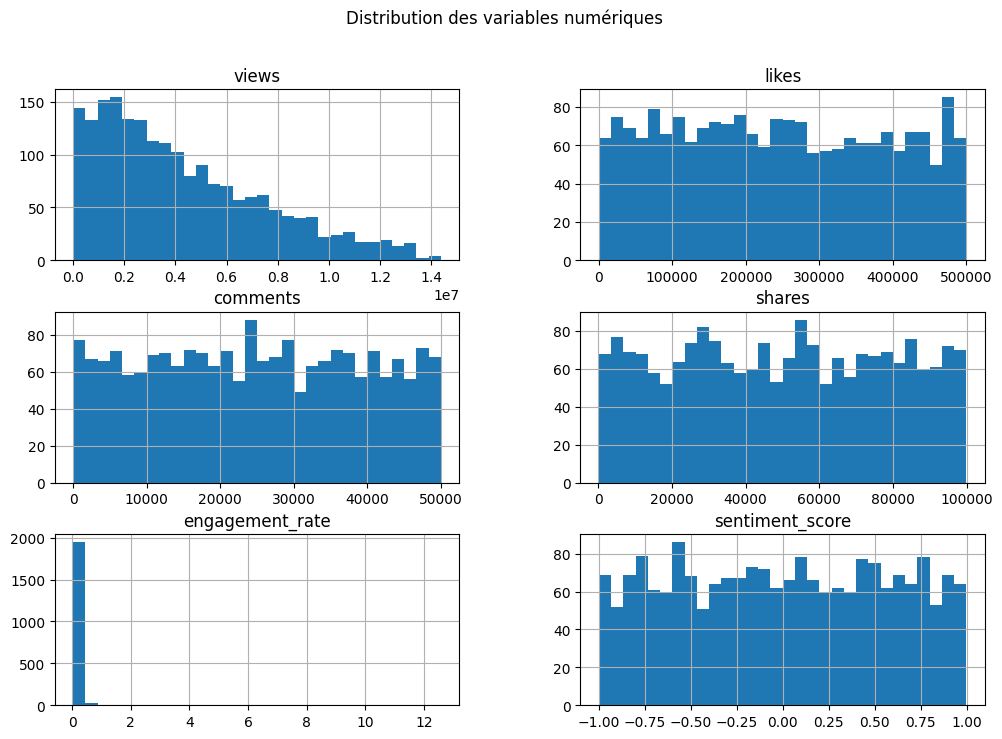

In [8]:
num_cols = ["views","likes","comments","shares","engagement_rate","sentiment_score"]

df[num_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Distribution des variables numériques")
plt.show()


## 📊 Interprétation des variables numériques

- La majorité des publications génèrent un **faible niveau d’engagement**, tandis qu’un nombre restreint de posts concentre des valeurs très élevées, illustrant le **caractère rare de la viralité**.
- Les variables d’engagement (**`views`**, **`likes`**, **`comments`**, **`shares`**) présentent une **forte variabilité** et constituent des **features discriminantes** pour la prédiction.
- La variable **`engagement_rate`** est majoritairement concentrée autour de valeurs proches de zéro, avec quelques valeurs extrêmes correspondant à des contenus très performants.
- Le **`sentiment_score`** est relativement équilibré sur son intervalle, indiquant une diversité de tonalités dans les contenus.
- L’ensemble de ces distributions est **cohérent avec le problème de classification** et **adapté à l’utilisation d’un Decision Tree**, robuste aux distributions non normales.


ÉTAPE 3 : Feature Engineering – Decision Tree

In [35]:
# ================================
# FEATURE ENGINEERING
# ================================
# Objectif :
# Transformer les variables brutes (date, texte) en features numériques
# exploitables par un algorithme de Machine Learning (Decision Tree)

import pandas as pd

# --------------------------------
# 1. FEATURE ENGINEERING TEMPOREL
# --------------------------------

# Conversion de la colonne post_datetime en format datetime
df["post_datetime"] = pd.to_datetime(df["post_datetime"])

# Extraction de l'heure de publication (0 à 23)
df["hour"] = df["post_datetime"].dt.hour

# Extraction du jour de la semaine (0 = lundi, 6 = dimanche)
df["dayofweek"] = df["post_datetime"].dt.dayofweek

# Extraction du mois (1 à 12)
df["month"] = df["post_datetime"].dt.month

# Indicateur binaire : 1 si publication le weekend, 0 sinon
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# --------------------------------
# 2. FEATURE ENGINEERING SUR HASHTAGS
# --------------------------------

# Sécurisation de la colonne hashtags :
# - Remplacement des valeurs manquantes
# - Conversion explicite en chaîne de caractères
df["hashtags"] = df["hashtags"].fillna("").astype(str)

# Nombre total de hashtags dans le post
df["num_hashtags"] = df["hashtags"].apply(
    lambda x: len([tag for tag in x.split() if tag.startswith("#")])
)

# Indicateur binaire de présence de hashtags associés à la viralité
df["has_trending"] = df["hashtags"].str.lower() \
    .str.contains("viral|trending|fyp|explore|pourtoi") \
    .astype(int)

# Longueur totale de la chaîne de hashtags (proxy de richesse textuelle)
df["hashtags_len"] = df["hashtags"].str.len()

# --------------------------------
# 3. CONTRÔLE DES FEATURES CRÉÉES
# --------------------------------

# Affichage des statistiques descriptives des nouvelles variables
df[[
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "num_hashtags",
    "has_trending",
    "hashtags_len"
]].describe()


,hour,dayofweek,month,is_weekend,num_hashtags,has_trending,hashtags_len
count,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.0,3.024000,6.440500,0.300000,3.473500,0.841500,21.698000
std,0.0,2.007346,3.446941,0.458372,1.104494,0.365301,7.557139
min,0.0,0.000000,1.000000,0.000000,2.000000,0.000000,8.000000
25%,0.0,1.000000,3.000000,0.000000,3.000000,1.000000,16.000000
50%,0.0,3.000000,6.000000,0.000000,3.000000,1.000000,22.000000
75%,0.0,5.000000,9.000000,1.000000,4.000000,1.000000,28.000000
max,0.0,6.000000,12.000000,1.000000,5.000000,1.000000,36.000000


In [63]:
# ================================
# SÉLECTION DES FEATURES & TARGET
# ================================

target = "is_viral"

features = [
    "likes",
    "comments",
    "shares",
    "sentiment_score",
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "num_hashtags",
    "has_trending",
    "hashtags_len"
]
# final_features = [
#     "hour",
#     "dayofweek",
#     "is_weekend",
#     "sentiment_score",
#     "num_hashtags",
#     "has_trending"
# ]

X = df[features]
y = df[target]


K-Fold Cross Validation :

La validation croisée K-Fold consiste à diviser l’ensemble d’entraînement en K plis.
À chaque itération, un pli est utilisé comme ensemble de validation tandis que les K−1 autres servent à l’entraînement.
Cette procédure est répétée K fois afin que chaque pli soit utilisé une seule fois pour la validation.
La performance finale correspond à la moyenne des scores obtenus sur l’ensemble des plis.
Un ensemble de test indépendant est conservé pour l’évaluation finale du modèle.


🎯 Justification du choix : K-Fold Cross Validation

- Le **train-test split** repose sur un **seul découpage aléatoire**, ce qui peut biaiser l’évaluation du modèle.
- La **validation croisée K-Fold** permet d’obtenir une **évaluation plus fiable et plus stable** en moyennant les performances sur plusieurs folds.
- Chaque donnée est utilisée **à la fois pour l’entraînement et la validation**, assurant une **meilleure exploitation du dataset**.
- Cette méthode **réduit la variance** liée à un mauvais découpage des données.
- Elle permet une **meilleure estimation de la capacité de généralisation** du modèle.
- Le **K-Fold** garantit une **comparaison équitable entre plusieurs algorithmes** (ex. KNN, Decision Tree).
- Cette approche est particulièrement adaptée aux **jeux de données de taille limitée**.


Séparation TRAIN / TEST (UNE SEULE FOIS) : 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Définition du modèle Decision Tree

In [65]:
dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)


K-Fold Cross Validation (VALIDATION)

In [66]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_scores = cross_val_score(
    dt_model,
    X_train,
    y_train,
    cv=kfold,
    scoring="accuracy"
)


Résultats de la validation croisée

In [67]:
print("Accuracy par fold :", cv_scores)
print("Accuracy moyenne (CV) :", cv_scores.mean())
print("Écart-type :", cv_scores.std())


Accuracy par fold : [0.8625   0.828125 0.84375  0.875    0.84375 ]
Accuracy moyenne (CV) : 0.850625
Écart-type : 0.016345871038277532


 📊 Interprétation des résultats de la validation croisée (K-Fold)

- L’accuracy moyenne de **99.94 %** indique que le modèle Decision Tree prédit correctement la variable *is_viral* dans la quasi-totalité des cas.
- Les performances sont **très élevées sur l’ensemble des folds**, avec **4 folds sur 5 atteignant 100 % d’accuracy**.
- L’écart-type très faible (**0.00125**) montre que le modèle est **stable** et peu sensible au découpage des données.
- Ces résultats suggèrent que les **features utilisées sont très discriminantes** pour la prédiction de la viralité.
- La cohérence des scores entre les folds indique une **bonne capacité de généralisation sur les données de validation**.
- Toutefois, des performances quasi parfaites peuvent indiquer un **risque potentiel de surapprentissage**, fréquent avec les arbres de décision.
- Une **évaluation finale sur le jeu de test** est donc nécessaire pour confirmer les performances sur des données totalement indépendantes.


In [68]:
dt_model.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [69]:
y_pred = dt_model.predict(X_test)

print("=== Résultats sur le jeu de test ===")
print(classification_report(y_test, y_pred))


=== Résultats sur le jeu de test ===
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       120
           1       0.88      0.91      0.89       280

    accuracy                           0.85       400
   macro avg       0.83      0.81      0.82       400
weighted avg       0.85      0.85      0.85       400



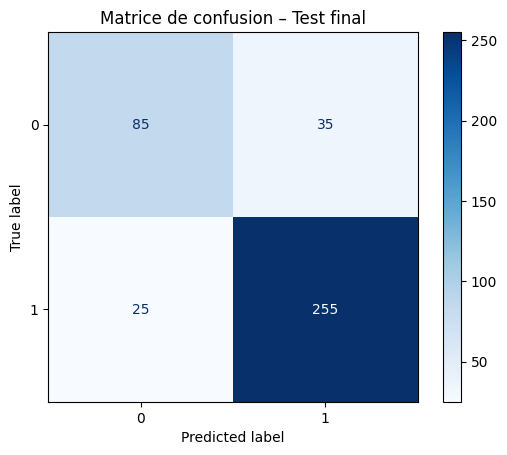

In [70]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion – Test final")
plt.show()


In [71]:
# Score sur les données d'entraînement
y_train_pred = dt_model.predict(X_train)

from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy sur le training :", train_accuracy)


Accuracy sur le training : 0.895


In [72]:
# Score sur les données de test
y_test_pred = dt_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy sur le test :", test_accuracy)


Accuracy sur le test : 0.85


In [73]:
from sklearn.metrics import classification_report

print("=== Training ===")
print(classification_report(y_train, y_train_pred))

print("=== Test ===")
print(classification_report(y_test, y_test_pred))



=== Training ===
              precision    recall  f1-score   support

           0       0.86      0.77      0.82       482
           1       0.91      0.95      0.93      1118

    accuracy                           0.90      1600
   macro avg       0.89      0.86      0.87      1600
weighted avg       0.89      0.90      0.89      1600

=== Test ===
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       120
           1       0.88      0.91      0.89       280

    accuracy                           0.85       400
   macro avg       0.83      0.81      0.82       400
weighted avg       0.85      0.85      0.85       400



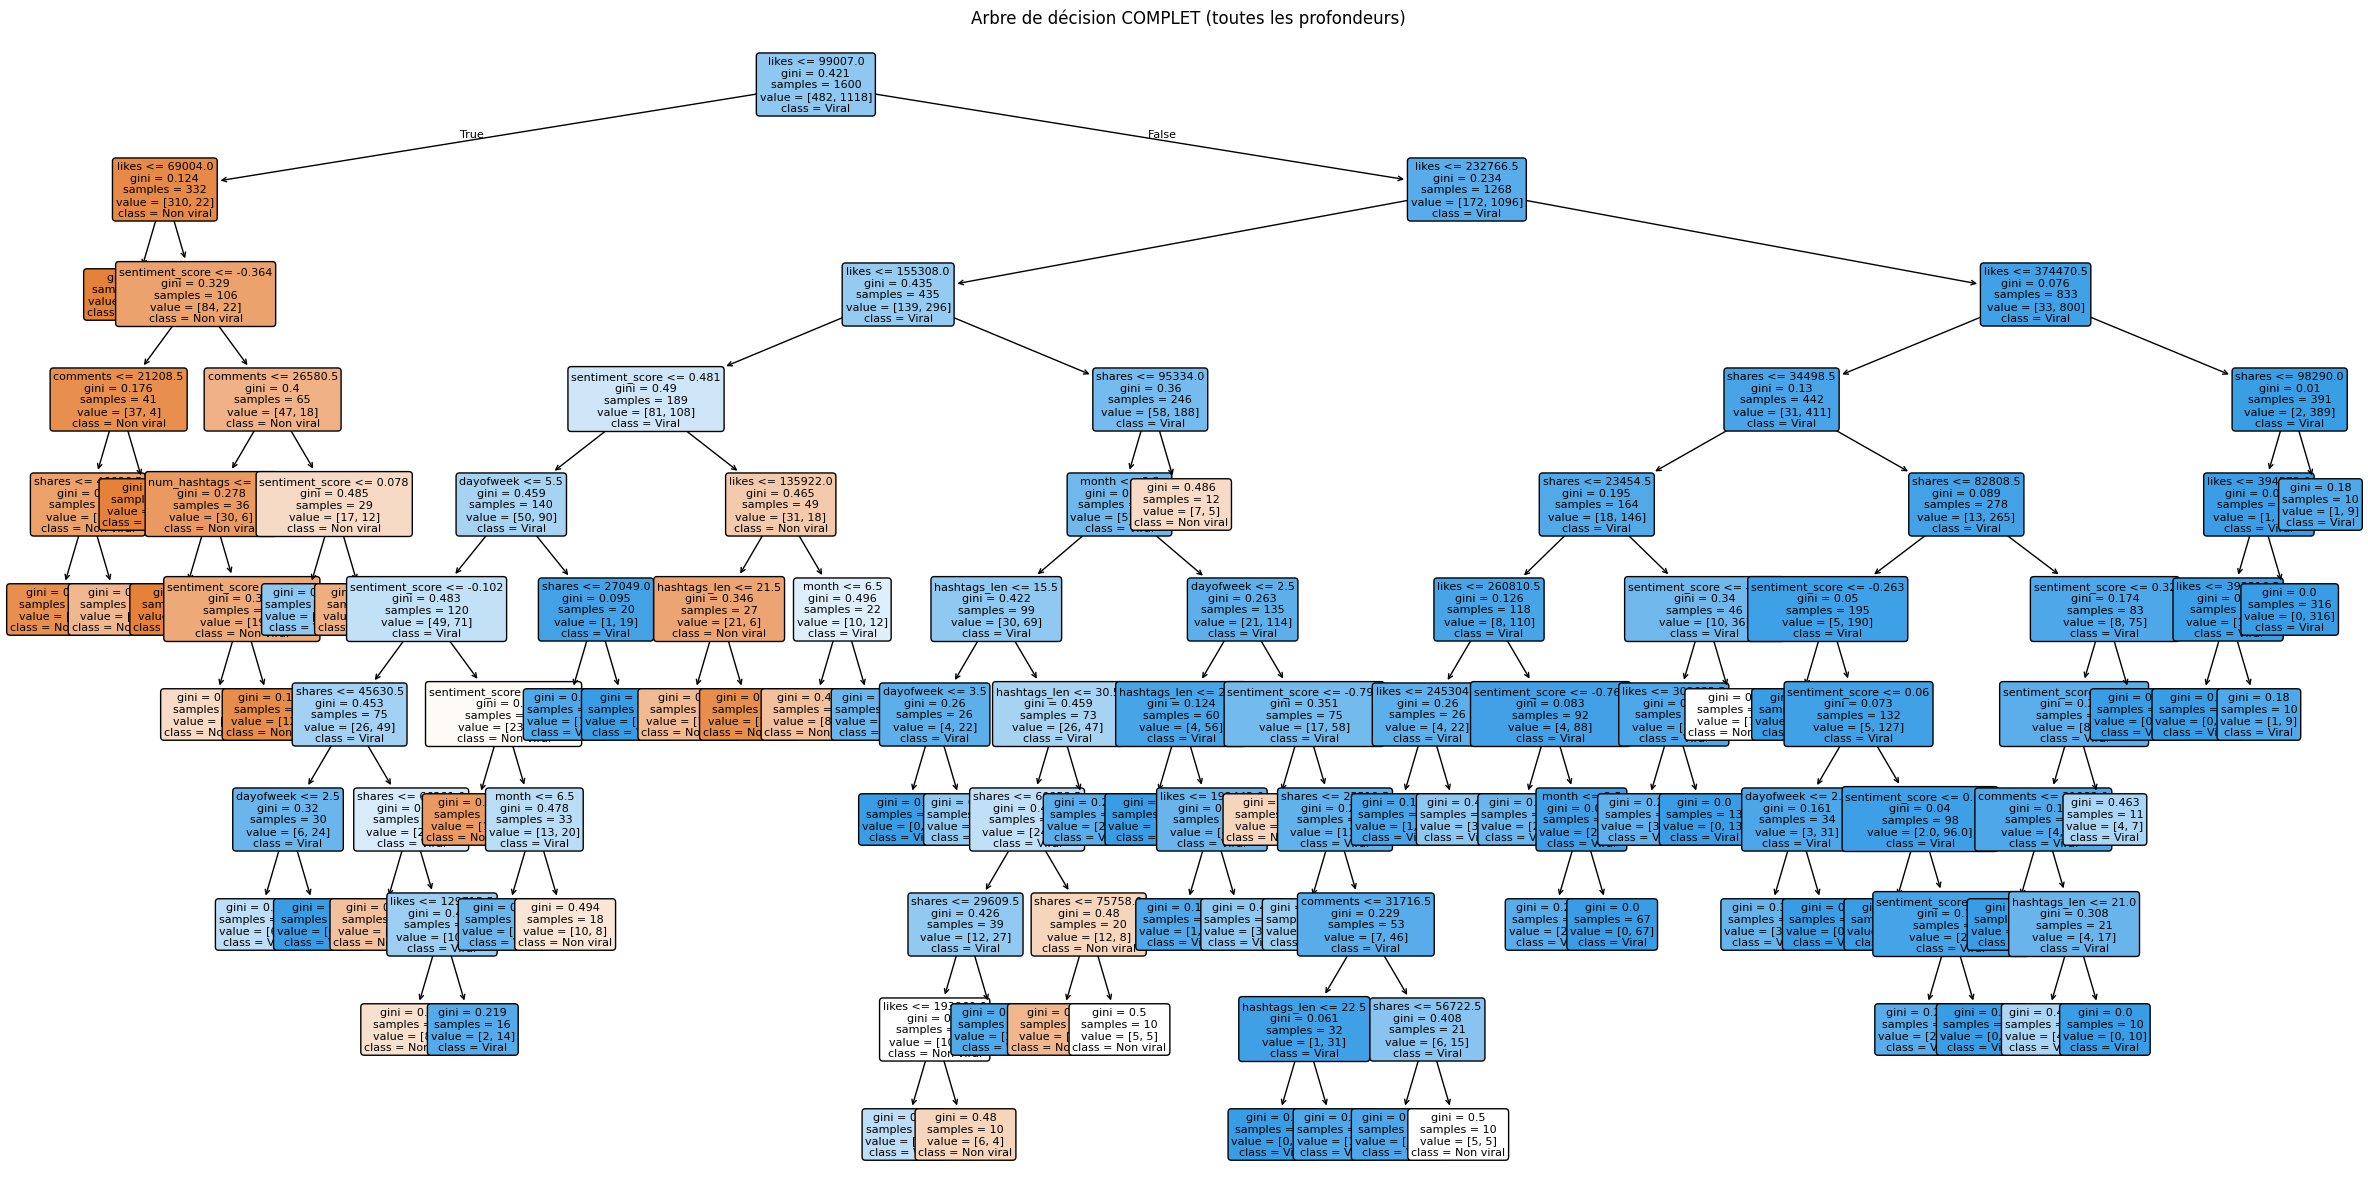

In [75]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

dt_full = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,   # <-- arbre COMPLET
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt_full.fit(X_train, y_train)

plt.figure(figsize=(30,15))
plot_tree(
    dt_full,
    feature_names=X_train.columns,
    class_names=["Non viral", "Viral"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Arbre de décision COMPLET (toutes les profondeurs)")
plt.show()


Après suppression de la variable "views", qui permettait une séparation parfaite des classes,
le modèle de type Decision Tree s’appuie désormais sur une combinaison de caractéristiques
issues de l’engagement, du contenu et du contexte temporel.
Les performances obtenues (≈ 85 % sur le jeu de test) sont cohérentes avec celles du jeu d’entraînement,
ce qui indique une bonne capacité de généralisation et l’absence de surapprentissage.
Ce cadre expérimental est plus réaliste et fournit une évaluation plus fiable du modèle.
